In [6]:
import pandas as pd
import datetime as dt
import backtrader as bt
import quantstats as qs
import matplotlib as plt
import numpy as np
import os

os.getcwd()

# 数据加载-------------------------------------
df = pd.read_csv("test_set.csv")  # 绝对路径
df.index = pd.to_datetime(df.date)
df['openinterest'] = 0

# #以下是自己随机添加signal的之后的文件，hmm算法给出的带signal的文件直接用上面的df=pd.read_csv导入，把下面到构建策略之前mute掉即可

# #随机生成一个-1，0，1的predictions序列---------
# sig=[]
# for i in range(len(df)):
#     x=np.random.randn()
#     if x > 0.2:
#         sig.append(1)
#     elif x<-0.2:
#         sig.append(-1)
#     else:
#         sig.append(0)
# df['signal']=sig


# 构建策略-------------------------------------
class TestSignalStrategy(bt.Strategy):
    params = ()

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (dt.isoformat(), txt))

    def __init__(self):
        self.bar_num = 0
        self.signal_df = df
        self.signal_df['date'] = pd.to_datetime(self.signal_df['date'])
        self.first_trade = True

    def prenext(self):
        self.next()

    def next(self):
        self.bar_num += 1
        current_date = self.datas[0].datetime.date(0).strftime("%Y-%m-%d")
        try:
            next_date = self.datas[0].datetime.date(1)
        except:
            next_date = None
        if next_date != None:
            next_signal_df = self.signal_df[self.signal_df['date'] == pd.to_datetime(
                next_date)]
            if len(next_signal_df) == 0:
                self.log("下个交易日的信号不存在")
            else:
                signal = int(next_signal_df['signal'])

                # 第一次交易没有底仓，只允许做多
                # 交易信号的执行方式：
                # 先不考虑卖空
                # signal为1，以当天开盘价全仓买入
                # signal为-1时，以当天开盘价卖出所有持仓
                if self.first_trade:
                    if signal == -1:
                        pass
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size = total_value//open_price
                        self.buy(self.datas[0],
                                 size=target_size, price=open_price)
                        self.first_trade = False
                else:
                    # 现有持仓
                    now_hold_size = self.getposition(self.datas[0]).size
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size = total_value//open_price
                        self.buy(self.datas[0],
                                 size=target_size, price=open_price)

                    if signal == -1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size = total_value//open_price
                        # 卖出开仓，手数不能超过底仓
                        if target_size > now_hold_size:
                            target_size = now_hold_size

                        self.sell(
                            self.datas[0], size=target_size, price=open_price)

    # 订单情况
    def notify_order(self, order):

        # 订单处于未决，继续
        if order.status in [order.Submitted, order.Accepted]:
            return

        # 订单已决
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行,%.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行,%2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Rejected, order.Expired]:
            self.log('订单 Canceled/Rejected/Expired')

    # 交易情况
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f , 佣金 %.2f'
                  % (trade.pnl, trade.pnlcomm, trade.commission))


cerebro = bt.Cerebro()

stock_df = df[['open', 'high', 'low', 'close', 'volume', 'openinterest']]
data = bt.feeds.PandasData(dataname=stock_df, fromdate=dt.datetime(
    2010, 1, 4), todate=dt.datetime(2021, 12, 31), timeframe=bt.TimeFrame.Days)
cerebro.adddata(data)

# 初始资金设置为10万
cerebro.broker.setcash(100000.0)
# 手续费万分之二
cerebro.broker.setcommission(commission=0.0002)
# 滑点设置 0.5%
cerebro.broker = bt.brokers.BackBroker(slip_perc=0.005)

cerebro.addstrategy(TestSignalStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

# 运行回测
print('start portfolio value:', format(cerebro.broker.getvalue()))
results = cerebro.run()
print('end portfolio value:', format(cerebro.broker.getvalue()))


# 绩效评价----------------------------
# 获取策略实例
start = results[0]
portfolio_stats = start.analyzers.getbyname('PyFolio')
# 以下returns为以日期为索引的资产日收益率序列
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

start portfolio value: 10000.0
2014-03-10,买单执行,2149.68
2014-03-11,卖单执行,2092.610000
毛收益 -228.28, 扣佣后收益 -228.28 , 佣金 0.00
2014-03-24,买单执行,2161.90
2014-04-04,卖单执行,2157.980000
毛收益 -15.68, 扣佣后收益 -15.68 , 佣金 0.00
2014-04-08,买单执行,2179.92
2014-04-22,卖单执行,2184.020000
毛收益 16.40, 扣佣后收益  16.40 , 佣金 0.00
2014-05-13,买单执行,2180.06
2014-05-22,卖单执行,2134.090000
毛收益 -183.88, 扣佣后收益 -183.88 , 佣金 0.00
2014-05-29,买单执行,2171.26
2014-06-05,卖单执行,2126.610000
毛收益 -178.60, 扣佣后收益 -178.60 , 佣金 0.00
2014-06-13,买单执行,2150.99
2014-06-20,卖单执行,2124.960000
毛收益 -104.12, 扣佣后收益 -104.12 , 佣金 0.00
2014-07-01,买单执行,2169.20
2014-07-11,卖单执行,2136.320000
毛收益 -131.52, 扣佣后收益 -131.52 , 佣金 0.00
2014-07-22,买单执行,2162.44
2014-08-14,卖单执行,2357.200000
毛收益 779.04, 扣佣后收益  779.04 , 佣金 0.00
2014-08-19,买单执行,2378.89
2014-08-26,卖单执行,2339.600000
毛收益 -157.16, 扣佣后收益 -157.16 , 佣金 0.00
2014-09-04,买单执行,2411.93
2014-09-17,卖单执行,2395.360000
2014-09-18,卖单执行,2396.380000
毛收益 -65.26, 扣佣后收益 -65.26 , 佣金 0.00
2014-10-08,买单执行,2460.87
2014-10-20,卖单执行,2448.450000
毛收益 -37

                    Strategy
------------------  ----------
Start Period        2010-01-04
End Period          2021-12-30
Risk-Free Rate      0.0%
Time in Market      37.0%

Cumulative Return   5.52%
CAGR﹪              0.45%

Sharpe              0.1
Sortino             0.14
Sortino/√2          0.1
Omega               1.03

Max Drawdown        -31.36%
Longest DD Days     2438

Gain/Pain Ratio     0.03
Gain/Pain (1M)      0.08

Payoff Ratio        1.05
Profit Factor       1.03
Common Sense Ratio  1.15
CPC Index           0.54
Tail Ratio          1.12
Outlier Win Ratio   13.27
Outlier Loss Ratio  3.2

MTD                 0.01%
3M                  0.01%
6M                  -6.01%
YTD                 -7.84%
1Y                  -7.84%
3Y (ann.)           3.4%
5Y (ann.)           2.43%
10Y (ann.)          -0.04%
All-time (ann.)     0.45%

Avg. Drawdown       -5.23%
Avg. Drawdown Days  307
Recovery Factor     0.18
Ulcer Index         0.18
Serenity Index      0.01


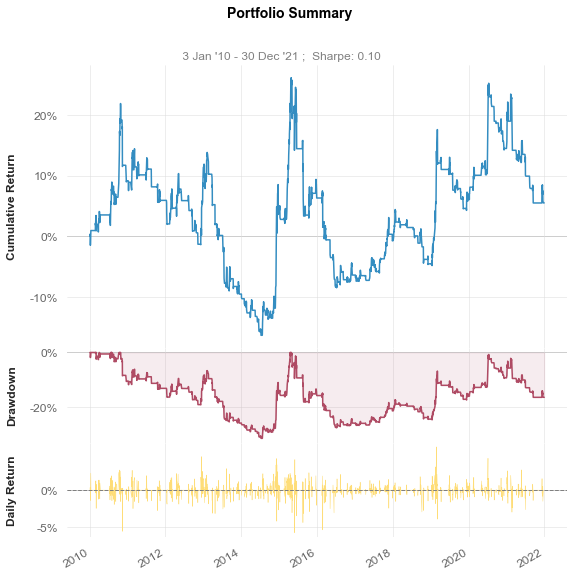

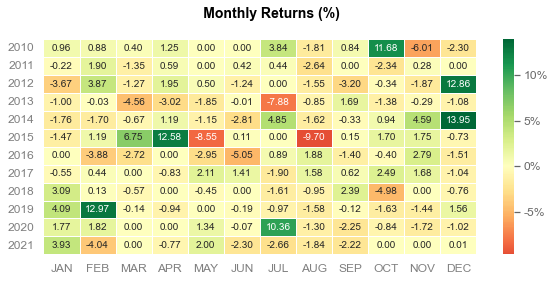

In [4]:
# 画图仍只能在notebook中输出(将basic改成full的话可以得到更多的输出结果，但其中一个return distribution的表会报错)
qs.reports.basic(returns, benchmark=None, rf=0.0,
                 grayscale=False, display=True, compounded=True)

                           Strategy
-------------------------  ----------
Start Period               2014-03-07
End Period                 2021-12-30
Risk-Free Rate             0.0%
Time in Market             44.0%

Cumulative Return          45.16%
CAGR﹪                     4.88%

Sharpe                     0.53
Smart Sharpe               0.51
Sortino                    0.78
Smart Sortino              0.75
Sortino/√2                 0.55
Smart Sortino/√2           0.53
Omega                      1.16

Max Drawdown               -21.32%
Longest DD Days            1377
Volatility (ann.)          10.3%
Calmar                     0.23
Skew                       -0.2
Kurtosis                   16.17

Expected Daily %           0.02%
Expected Monthly %         0.4%
Expected Yearly %          4.77%
Kelly Criterion            6.87%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.05%
Expected Shortfall (cVaR)  -1.05%

Gain/Pain Ratio            0.16
Gain/Pain (1M)             0.5

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-05-27,2016-07-08,2019-03-04,1377,-21.318517,-21.072923
2,2020-07-14,2021-09-16,2021-12-30,534,-11.956942,-11.950513
3,2014-04-11,2014-07-11,2014-11-27,230,-9.446671,-9.188858
4,2014-12-23,2015-02-25,2015-04-10,108,-9.428368,-8.989335
5,2019-07-03,2019-12-12,2020-02-20,232,-6.266587,-5.971503


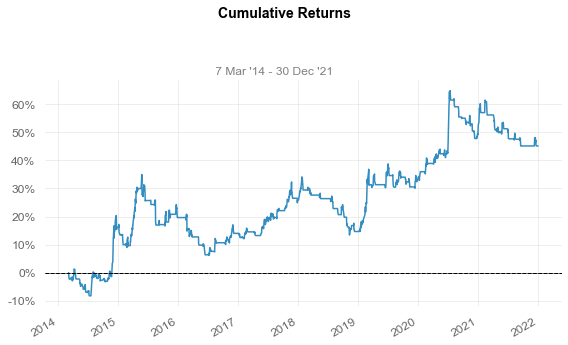

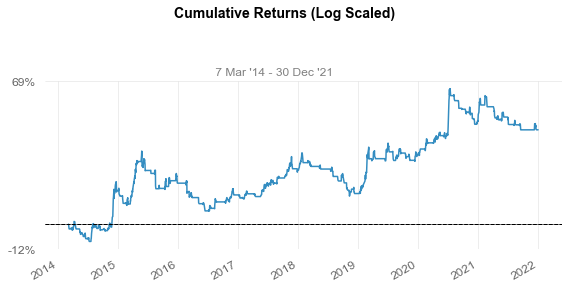

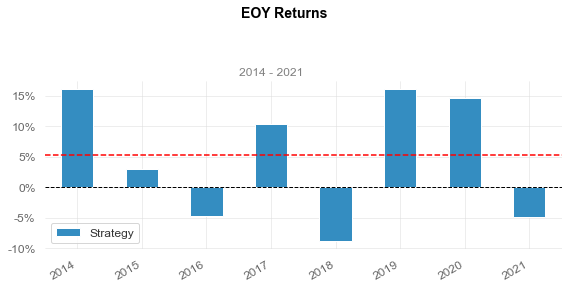

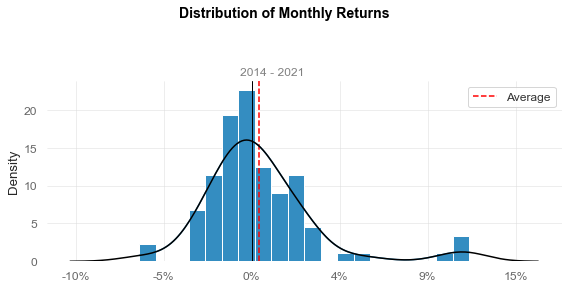

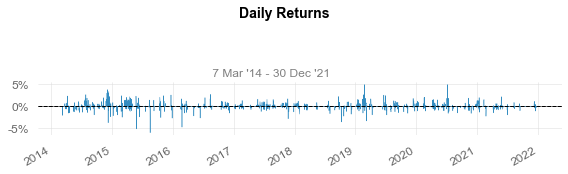

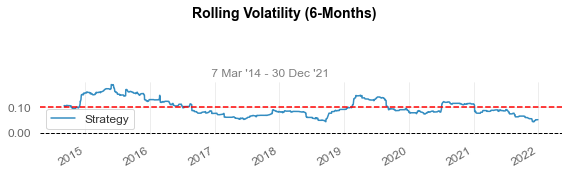

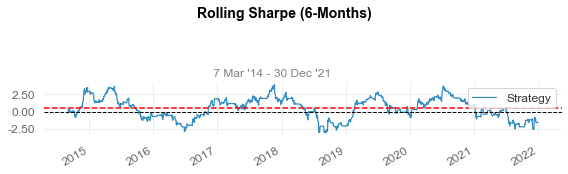

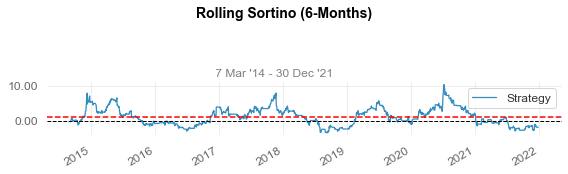

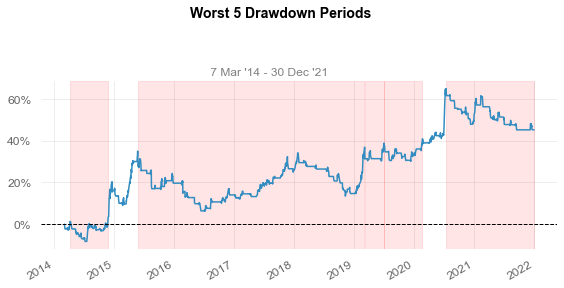

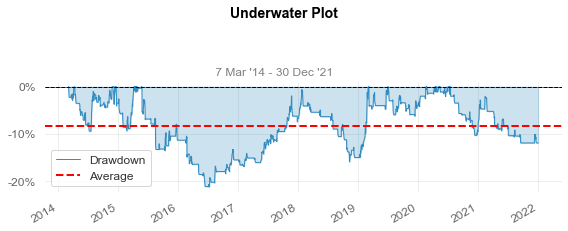

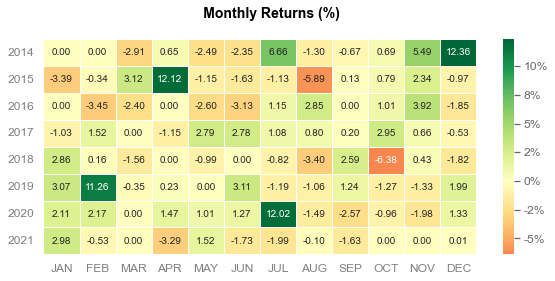

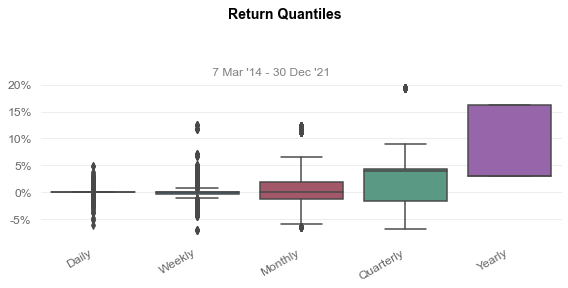

In [7]:
# 画图仍只能在notebook中输出
qs.reports.full(returns, benchmark=None, rf=0.0,
                grayscale=False, display=True, compounded=True)